In [223]:
import importlib
import data_preprocessor
import helper_functions
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from helper_functions import load_dataset, save_dataset
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from data_preprocessor import DataPreprocessor
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, BisectingKMeans, DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics.pairwise import cosine_distances
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import matplotlib.cm as cm
from sklearn.model_selection import StratifiedKFold

importlib.reload(data_preprocessor)
importlib.reload(helper_functions)

import warnings
warnings.filterwarnings('ignore')

### Loading the dataset

In [224]:
data = load_dataset("../data/assignment3_articles.xlsx")

## 1) Data Inspection and Preparation

First, we do some basic inspection of the dataset, such as checking the first few rows, the data types, the amount of missing values, and the value counts of certain columns.

In [225]:
data

,index,headlines,description,content
0,0,Rupee ends 1 paisa lower at 83.38 against US d...,"Besides, selling pressure in the domestic equi...",The rupee consolidated in a narrow range and s...
1,1,"India vs Syria Live Streaming, AFC Asian Cup 2...","AFC Asian Cup Live Streaming, India vs Syria F...",India vs Syria AFC Asia Cup Live Streaming Det...
2,2,"PM Modi to interact with VCs, teachers, studen...",G20 University Connect: The commission has ask...,The University Grants Commission (UGC) is orga...
3,3,"How to remove bloatware apps from Samsung, Rea...",Smartphone companies often ship Android phones...,Smartphone manufacturers often pack new Androi...
4,4,NEET SS 2023 result declared; counselling sche...,NEET SS 2023 Result: Candidates who appeared f...,The National Board of Examinations Medical Sci...
...,...,...,...,...
2495,2495,Google Search and Lens can now visualise STEM ...,Google Search and Lens can now help students w...,Google has been consistently improving its Sea...
2496,2496,Arsenal’s Partey an injury doubt as Arteta rel...,Partey came off at halftime during Arsenal's F...,Arsenal midfielder Thomas Partey is still an i...
2497,2497,"iQOO 12 will get 3 Android updates, will not h...","iQOO says its upcoming flagship phone, running...",iQOO is all set to launch its upcoming flagshi...
2498,2498,Lava Blaze Pro 5G review: Is this the best 5G ...,Lava Blaze Pro 5G is an excellent 5G smartphon...,"In less than a year, India has accounted for o..."


In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        2500 non-null   int64 
 1   headlines    2500 non-null   object
 2   description  2500 non-null   object
 3   content      2500 non-null   object
dtypes: int64(1), object(3)
memory usage: 78.2+ KB


### Preprocessing the text data

In [227]:
# Initialize the DataPreprocessor object
preprocessor = DataPreprocessor()

We quickly how below how the preprocessor works by applying it to the first row of the content column.

In [228]:
# get first row and last column
data.iloc[0, -1]

'The rupee consolidated in a narrow range and settled 1 paisa lower at 83.38 (provisional) against the US dollar on Tuesday, as investors preferred to remain cautious ahead of the domestic inflation data release and upcoming US Fed meeting.\nBesides, selling pressure in the domestic equity markets dented market sentiments, forex traders said.\nHowever, a weaker American currency against major currencies overseas restricted the loss in the local currency, they added.\nADVERTISEMENT\nAt the interbank foreign exchange market, the local unit opened at 83.36 and settled at 83.38 (provisional) against the greenback, registering a loss of 1 paisa from its previous close.\nDuring intra-day, the rupee touched a high of 83.35 and hit the lowest level of 83.39.\nOn Monday, the domestic currency settled at 83.37 against the US dollar.\nInvestors largely remained concerned over the domestic inflation data as well as industrial production numbers to be announced later in the day.\nADVERTISEMENT\nCur

In [229]:
preprocessor.preprocess_text(data.iloc[0, -1])

'rupe consolid narrow rang settl paisa lower provision us dollar tuesday investor prefer remain cautiou ahead domest inflat data releas upcom us fed meet besid sell pressur domest equiti market dent market sentiment forex trader said howev weaker american currenc major currenc oversea restrict loss local currenc ad interbank foreign exchang market local unit open settl provision greenback regist loss paisa previou close intraday rupe touch high hit lowest level monday domest currenc settl us dollar investor larg remain concern domest inflat data well industri product number announc later day currenc trader also await us feder reserv monetari polici decis like announc later week upcom focu us cpi data even expect per cent monthonmonth basi lower yearonyear figur per cent anticip mix reaction rupe seem unaffect persist within broad rang jateen trivedi vp research analyst lkp secur said meanwhil dollar index gaug greenback strength basket six currenc trade per cent lower tuesday brent cru

### Data Preprocessing

In [230]:
def count_numbers(text):
    """
    Count the occurrences of numbers in the text.
    """
    # match numbers
    pattern = r'\b\d+[,.]\d+\b|\b\d+[,.]?\b|\b[,.]\d+\b'
    return len(re.findall(pattern, text))

def preprocess_col(preprocessor: DataPreprocessor, col: pd.Series, h_pct: float = 0, l_pct: float = 0) -> pd.Series:
    """ 
    Preprocesses a column of text data using the preprocessor (cfr. data_preprocessor.py), 
    and by removing the top $h_pct of the most frequent words and the top $l_pct of the least frequent words.
    
    Inspired partly by: https://medium.com/analytics-vidhya/introduction-to-text-classification-in-python-659eccf6b2e
    
    :param preprocessor: preprocessor object
    :param col: column of text data
    :param h_pct: "the percentage of high frequency words to remove from the corpus"
    :param l_pct: "the percentage of low frequency words to remove from the corpus"
    :return: preprocessed column
    """

    col = col.apply(preprocessor.preprocess_text)
    
    if h_pct != 0:
        #removing the top $h_pct of the most frequent words 
        high_freq = pd.Series(' '.join(col).split()).value_counts()[:int(pd.Series(' '.join(col).split()).count()*h_pct/100)]
        rem_high = col.apply(lambda x: " ".join(x for x in x.split() if x not in high_freq))
    else:
        rem_high = col
    
    if l_pct != 0:
        #removing the top $l_pct of the least frequent words
        low_freq = pd.Series(' '.join(rem_high).split()).value_counts()[:-int(pd.Series(' '.join(rem_high).split()).count()*l_pct/100):-1]
        rem_low = rem_high.apply(lambda x: " ".join(x for x in x.split() if x not in low_freq))
    else:
        rem_low = rem_high
    
    return rem_low

We concatenate the headlines, descriptions, and preprocessed content columns into a single column, and preprocess the concatenated column.

In [231]:
# count amount of numbers in content column
data['amount_of_numbers'] = data['content'].apply(count_numbers)

data['preprocessed_content'] = preprocess_col(preprocessor, data['content'], h_pct=1, l_pct=1)
data['concatenated'] = data['headlines'] + ' ' + data['description'] + ' ' + data['preprocessed_content']
data['preprocessed_concat'] = preprocess_col(preprocessor, data['concatenated'], h_pct=0, l_pct=0)

data_preprocessed = data.drop(columns=['headlines', 'description', 'content', 'preprocessed_content', 'concatenated'])

In [232]:
data_preprocessed

,index,amount_of_numbers,preprocessed_concat
0,0,27,rupe end paisa lower us dollar besid sell pres...
1,1,5,india vs syria live stream afc asian cup watch...
2,2,4,pm modi interact vc teacher student ugc univer...
3,3,0,remov bloatwar app samsung realm xiaomi vivo r...
4,4,2,neet ss result declar counsel schedul soon nat...
...,...,...,...
2495,2495,0,googl search len visualis stem model help calc...
2496,2496,1,arsen partey injuri doubt arteta reli jorginho...
2497,2497,10,iqoo get android updat hot app hot game iqoo s...
2498,2498,1,lava blaze pro review best phone rs lava blaze...


We vectorize the preprocessed text data using the TF-IDF method.

In [233]:
vectorizer = TfidfVectorizer()
# vectorizer = CountVectorizer()
vectorized_data = vectorizer.fit_transform(data_preprocessed['preprocessed_concat']) # Vectorize preprocessed text data
vectorized_data_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_features = vectorized_data_df.copy()

In [234]:
tfidf_features

,aa,aaa,aac,aacha,aacsb,aadat,aadhaar,aadhaarvalid,aadhya,aadmi,...,zonewhuev,zoolog,zoom,zorzi,zouma,zoya,zozo,zuckerberg,zulfon,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Clustering

In [235]:
def elbow_method_plot(model, tfidf_features, max_k, use_own_function=False):
    """
    Plots the Elbow Method graph for optimal k in KMeans clustering.
    :param model: 
    :param tfidf_features: 
    :param max_k: 
    :return: 
    """
    if use_own_function:
        sse = []  # List to store SSE values for different k
    
        for k in range(1, max_k + 1):
            m = model.__class__(n_clusters=k, random_state=42)
            m.fit(tfidf_features)
            sse.append(m.inertia_)
    
        # Plot SSE vs. number of clusters (k)
        plt.figure(figsize=(6, 4))
        plt.plot(range(1, max_k + 1), sse, marker='o')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Sum of Squared Errors (SSE)')
        plt.title('Elbow Method for Optimal k')
        plt.xticks(range(1, max_k + 1))
        plt.grid(True)
        plt.show()
    else:
        model = model.__class__(random_state=42)
        visualizer = KElbowVisualizer(model, k=(1,max_k+1))
        visualizer.fit(tfidf_features)
        visualizer.show()
        plt.show()

### KMeans

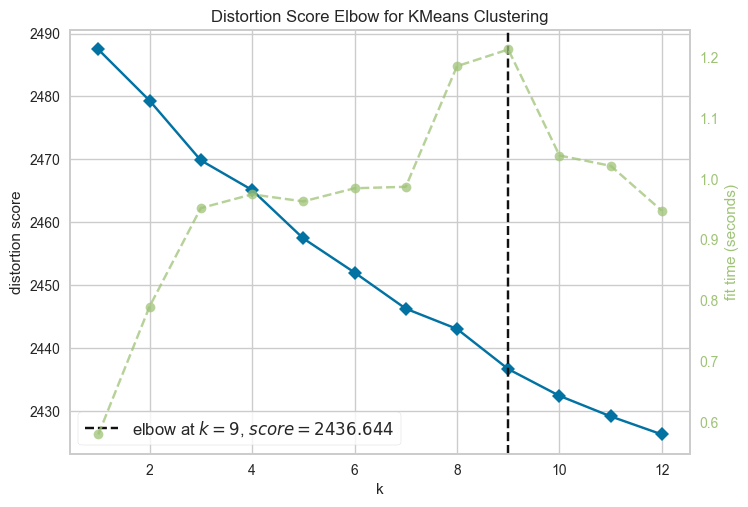

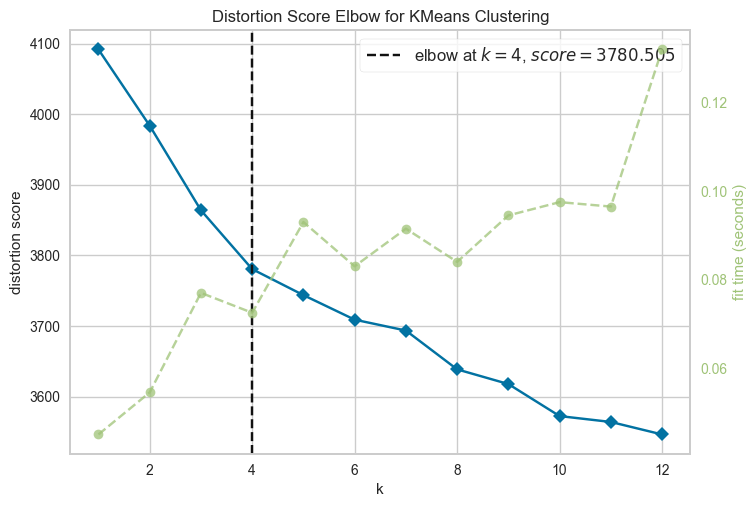

In [236]:
elbow_method_plot(KMeans(), tfidf_features, max_k=12)
elbow_method_plot(KMeans(), cosine_distances(tfidf_features), max_k=12)

In [237]:
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_features)
cluster_labels = kmeans.labels_

# Evaluate clustering using silhouette score (optional)
silhouette_avg = silhouette_score(tfidf_features, cluster_labels)
print("Silhouette Score:", silhouette_avg)
print("Inertia:", kmeans.inertia_)

# Assign cluster labels to documents in the dataset
tfidf_features['cluster'] = cluster_labels

Silhouette Score: 0.005102563804499803
Inertia: 2446.2535856264767


In [238]:
tfidf_features['cluster'].value_counts()

cluster
4    1399
3     252
0     251
2     237
6     199
5      96
1      66
Name: count, dtype: int64

In [239]:
centroids = kmeans.cluster_centers_
feature_names = vectorizer.get_feature_names_out()

# Print top words for each cluster
for i in range(num_clusters):
    cluster_center = centroids[i]
    top_indices = cluster_center.argsort()[::-1][:10]  # Get indices of top 10 words
    top_words = [feature_names[idx] for idx in top_indices]  # Map indices to words
    print(f"Cluster {i+1}: {', '.join(top_words)}")

Cluster 1: exam, ug, result, neet, cuet, check, jee, offici, class, websit
Cluster 2: collect, kapoor, box, offic, ranbir, anim, day, film, rs, crore
Cluster 3: per, cent, rs, crore, bank, price, inflat, rbi, sensex, rate
Cluster 4: test, australia, vs, india, cup, world, cricket, women, kohli, ind
Cluster 5: india, year, said, ai, student, say, new, film, indian, iit
Cluster 6: khan, rukh, shah, dunki, ali, salman, film, aamir, suhana, ira
Cluster 7: appl, googl, featur, new, app, galaxi, news, pro, ai, tech


In [240]:
def plot_tsne_pca(data, labels):

    max_label = max(labels)+1

    # Perform PCA
    if isinstance(data, np.ndarray):
        pca = PCA(n_components=2, random_state=42).fit_transform(data)
        # Perform t-SNE
        tsne = TSNE(init="random", random_state=42).fit_transform(data)
        
    else:
        pca = PCA(n_components=2, random_state=42).fit_transform(data.toarray())
        # Perform t-SNE
        tsne = TSNE(init="random", random_state=42).fit_transform(data.toarray())

    

    # Define unique labels
    unique_labels = np.unique(labels)

    # Map labels to colors
    label_colors = [cm.hsv(i / max_label) for i in labels]
    color_map = [cm.hsv(i / max_label) for i in unique_labels]

    # Create subplots
    f, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot PCA results
    scatter_pca = ax[0].scatter(pca[:, 0], pca[:, 1], c=label_colors)
    ax[0].set_title('PCA Cluster Plot')

    # Plot t-SNE results
    scatter_tsne = ax[1].scatter(tsne[:, 0], tsne[:, 1], c=label_colors)
    ax[1].set_title('TSNE Cluster Plot')

    # Create legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[i], markersize=10) for i in range(len(unique_labels))]
    ax[0].legend(handles, [f'Cluster {i}' for i in unique_labels], title='Clusters')
    ax[1].legend(handles, [f'Cluster {i}' for i in unique_labels], title='Clusters')

    plt.show()

def plot_clusters_2d(text_data, clusters):
    # Apply PCA to reduce the dimensionality to 2
    pca = PCA(n_components=2, random_state=42)
    if isinstance(text_data, np.ndarray):
        reduced_features = pca.fit_transform(text_data)
    else:
        reduced_features = pca.fit_transform(text_data.toarray())

    # Plot the clusters
    plt.figure(figsize=(8, 6))
    colors = ['tab:orange', 'tab:olive', 'tab:pink', 'b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define colors for each cluster
    for i in range(len(set(clusters))):
        plt.scatter(reduced_features[clusters == i, 0], reduced_features[clusters == i, 1], 
                    color=colors[i], label=f'Cluster {i}')

    plt.title('Clustering in 2D using PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()
    
# Function to plot clusters using SVD
def plot_clusters_svd_2d(text_data, clusters):
    # Apply TruncatedSVD to reduce the dimensionality to 2
    svd = TruncatedSVD(n_components=2, random_state=42)
    reduced_features = svd.fit_transform(text_data)

    # Plot the clusters
    plt.figure(figsize=(8, 6))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define colors for each cluster
    for i in range(len(set(clusters))):
        plt.scatter(reduced_features[clusters == i, 0], reduced_features[clusters == i, 1], 
                    color=colors[i], label=f'Cluster {i}')

    plt.title('Clustering in 2D using SVD')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()
    
def plot_clusters_2d_all(text_data, clusters):
    # Define the number of clusters
    n_clusters = len(set(clusters))

    # Define colors for clusters
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'tab:orange', 'tab:olive', 'tab:pink', 'tab:brown'] # [cm.tab10(i/float(n_clusters)) for i in range(n_clusters)]

    # Apply PCA to reduce the dimensionality to 2
    pca = PCA(n_components=2, random_state=42)
    if isinstance(text_data, np.ndarray):
        reduced_features_pca = pca.fit_transform(text_data)
    else:
        reduced_features_pca = pca.fit_transform(text_data.toarray())

    # Apply TruncatedSVD to reduce the dimensionality to 2
    svd = TruncatedSVD(n_components=2, random_state=42)
    reduced_features_svd = svd.fit_transform(text_data)

    # Apply t-SNE to reduce the dimensionality to 2
    tsne = TSNE(n_components=2, init="random", random_state=42)
    reduced_features_tsne = tsne.fit_transform(text_data)

    # Create subplots
    f, ax = plt.subplots(1, 3, figsize=(21, 6))

    # Plot PCA results
    for i in range(n_clusters):
        ax[0].scatter(reduced_features_pca[clusters == i, 0], reduced_features_pca[clusters == i, 1], 
                      color=colors[i], label=f'Cluster {i}')
    ax[0].set_title('PCA Cluster Plot')
    ax[0].set_xlabel('Principal Component 1')
    ax[0].set_ylabel('Principal Component 2')

    # Plot SVD results
    for i in range(n_clusters):
        ax[1].scatter(reduced_features_svd[clusters == i, 0], reduced_features_svd[clusters == i, 1], 
                      color=colors[i], label=f'Cluster {i}')
    ax[1].set_title('SVD Cluster Plot')
    ax[1].set_xlabel('Component 1')
    ax[1].set_ylabel('Component 2')

    # Plot t-SNE results
    for i in range(n_clusters):
        ax[2].scatter(reduced_features_tsne[clusters == i, 0], reduced_features_tsne[clusters == i, 1], 
                      color=colors[i], label=f'Cluster {i}')
    ax[2].set_title('t-SNE Cluster Plot')
    ax[2].set_xlabel('Component 1')
    ax[2].set_ylabel('Component 2')

    # Add legend to the first subplot
    ax[0].legend()
    
    plt.show()

tfidf = TfidfVectorizer()
tfidf.fit(data.preprocessed_concat)
text = tfidf.transform(data.preprocessed_concat)

# clusters = KMeans(n_clusters=7, random_state=20).fit_predict(text)

# plot_tsne_pca(text, clusters)
# plot_clusters_2d(text, clusters)

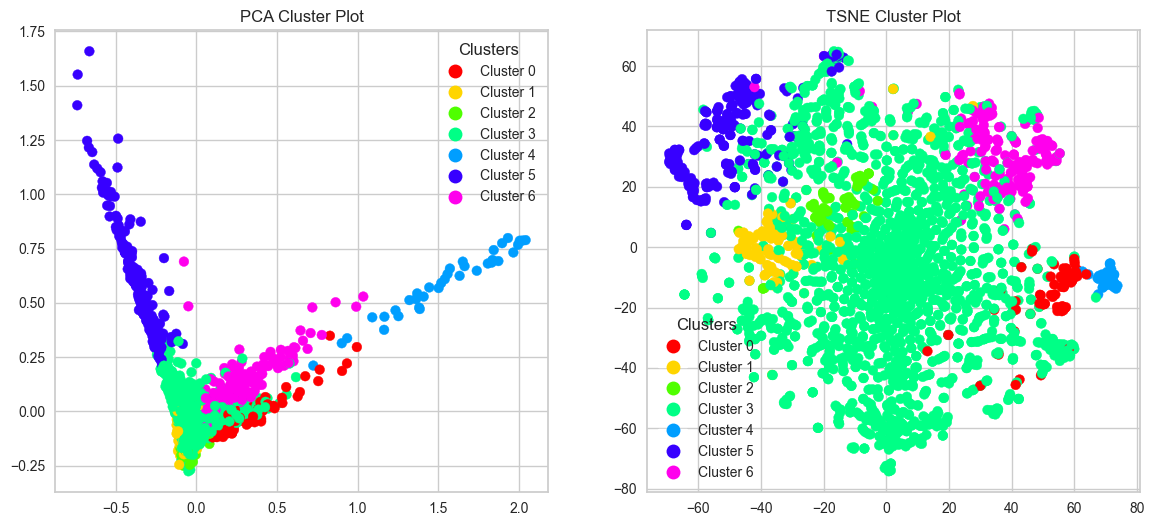

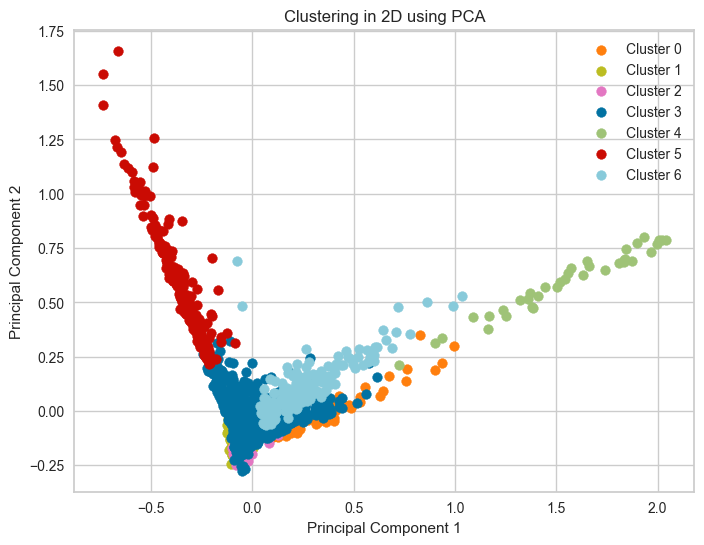

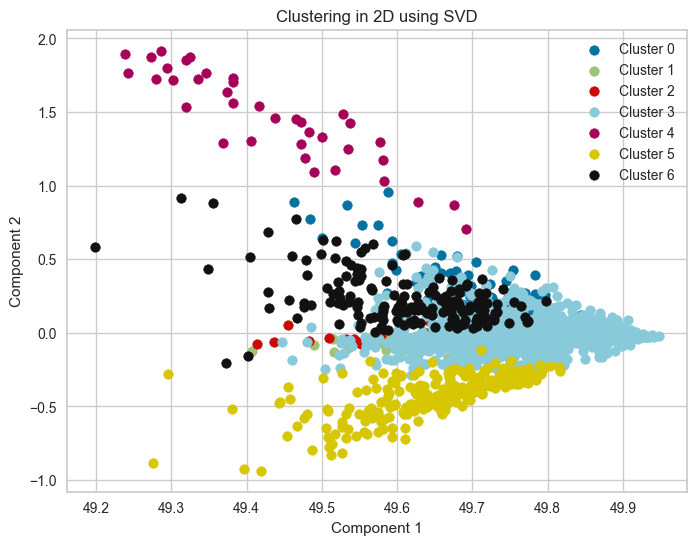

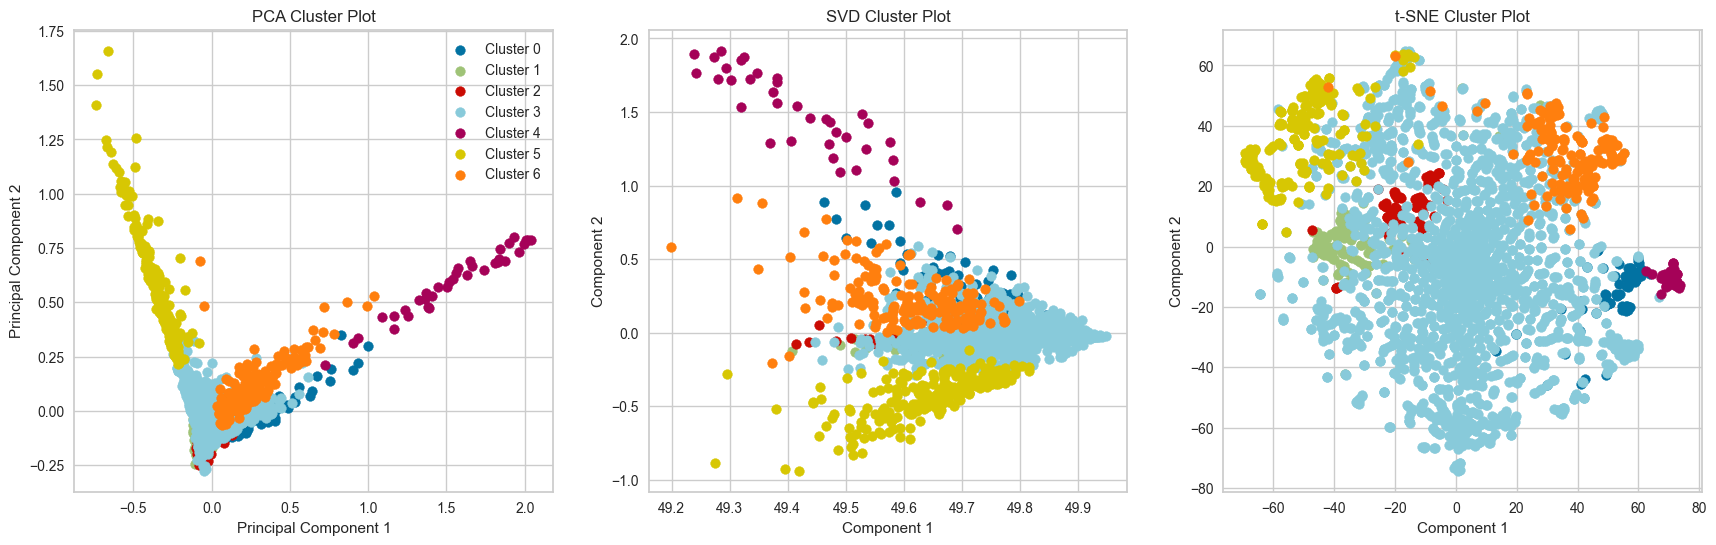

In [241]:
tfidf = TfidfVectorizer()
tfidf.fit(data.preprocessed_concat)
text = tfidf.transform(data.preprocessed_concat)
text = cosine_distances(text)
kmeans = KMeans(n_clusters=7, random_state=20)
clusters = kmeans.fit_predict(text)

plot_tsne_pca(text, clusters)
plot_clusters_2d(text, clusters)
plot_clusters_svd_2d(text, clusters)
plot_clusters_2d_all(text, clusters)

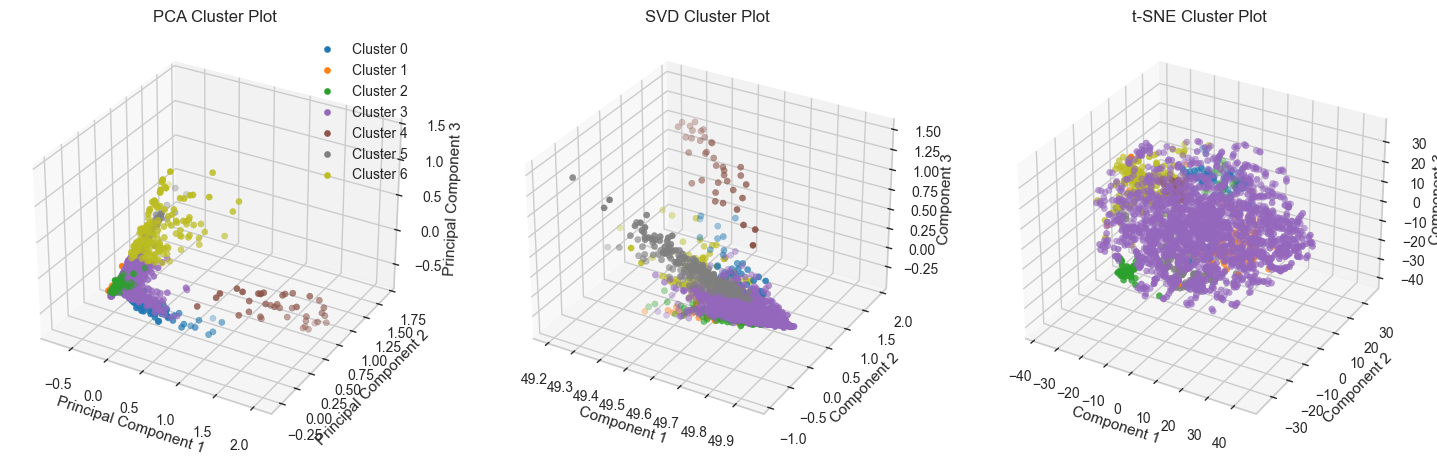

In [242]:
def plot_clusters_3d_all(text_data, clusters):
    # Define the number of clusters
    n_clusters = len(set(clusters))

    # Define colors for clusters
    colors = [cm.tab10(i/float(n_clusters)) for i in range(n_clusters)]

    # Apply PCA to reduce the dimensionality to 3
    pca = PCA(n_components=3, random_state=42)
    if isinstance(text_data, np.ndarray):
        reduced_features_pca = pca.fit_transform(text_data)
    else:
        reduced_features_pca = pca.fit_transform(text_data.toarray())

    # Apply TruncatedSVD to reduce the dimensionality to 3
    svd = TruncatedSVD(n_components=3, random_state=42)
    reduced_features_svd = svd.fit_transform(text_data)

    # Apply t-SNE to reduce the dimensionality to 3
    tsne = TSNE(n_components=3, init="random", random_state=42)
    reduced_features_tsne = tsne.fit_transform(text_data)

    # Create subplots
    fig = plt.figure(figsize=(18, 6))

    # Plot PCA results in 3D
    ax1 = fig.add_subplot(131, projection='3d')
    for i in range(n_clusters):
        ax1.scatter(reduced_features_pca[clusters == i, 0], reduced_features_pca[clusters == i, 1], 
                    reduced_features_pca[clusters == i, 2], color=colors[i], label=f'Cluster {i}')
    ax1.set_title('PCA Cluster Plot')
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.set_zlabel('Principal Component 3')

    # Plot SVD results in 3D
    ax2 = fig.add_subplot(132, projection='3d')
    for i in range(n_clusters):
        ax2.scatter(reduced_features_svd[clusters == i, 0], reduced_features_svd[clusters == i, 1], 
                    reduced_features_svd[clusters == i, 2], color=colors[i], label=f'Cluster {i}')
    ax2.set_title('SVD Cluster Plot')
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    ax2.set_zlabel('Component 3')

    # Plot t-SNE results in 3D
    ax3 = fig.add_subplot(133, projection='3d')
    for i in range(n_clusters):
        ax3.scatter(reduced_features_tsne[clusters == i, 0], reduced_features_tsne[clusters == i, 1], 
                    reduced_features_tsne[clusters == i, 2], color=colors[i], label=f'Cluster {i}')
    ax3.set_title('t-SNE Cluster Plot')
    ax3.set_xlabel('Component 1')
    ax3.set_ylabel('Component 2')
    ax3.set_zlabel('Component 3')

    # Add legend to the first subplot
    ax1.legend()

    plt.show()

# Plotting the clusters
plot_clusters_3d_all(text, clusters)

In [243]:
centroids = kmeans.cluster_centers_
feature_names = tfidf.get_feature_names_out()
num_clusters = 7

# Print top words for each cluster
for i in range(num_clusters):
    cluster_center = centroids[i]
    top_indices = cluster_center.argsort()[::-1][:10]  # Get indices of top 10 words
    top_words = [feature_names[idx] for idx in top_indices]  # Map indices to words
    print(f"Cluster {i+1}: {', '.join(top_words)}")

Cluster 1: avlani, agre, ak, adfre, admiss, appreci, almost, alloc, annadata, aser
Cluster 2: behrendorff, afi, betray, berth, alongwith, bachelor, blur, attest, barrel, bauhausuniv
Cluster 3: admiss, bachelor, aprilnovemb, agre, admonish, barrel, attrit, aparna, bacho, beetl
Cluster 4: agre, ag, admiss, aparna, battlefield, assent, aagi, ali, adfre, aishwarya
Cluster 5: alvarez, bachan, abyss, aug, adfre, bash, ahmedabad, azim, binni, alpha
Cluster 6: barrel, amfi, bnp, bachelor, ambul, arsenio, aiyaaa, ar, backcourt, biodivers
Cluster 7: apparatu, ajl, adfre, airborn, afridi, bopannabhambri, abdul, bendebka, bound, arnold


### Bisecting KMeans

In [244]:
tfidf_features = vectorized_data_df
num_clusters = 7
bkmeans = BisectingKMeans(n_clusters=num_clusters, random_state=42)
bkmeans.fit(tfidf_features)
cluster_labels = bkmeans.labels_

# Evaluate clustering using silhouette score
silhouette_avg = silhouette_score(tfidf_features, cluster_labels)
print("Silhouette Score:", silhouette_avg)
print("Inertia:", bkmeans.inertia_)

# Assign cluster labels to documents in the dataset
tfidf_features['cluster'] = cluster_labels

Silhouette Score: 0.0036343706278808086
Inertia: 2457.262642599124


### KMedoids

In [245]:
tfidf_features = vectorized_data_df
num_clusters = 7
kmedoids = KMedoids(n_clusters=num_clusters, random_state=42)
kmedoids.fit(tfidf_features)
cluster_labels = kmedoids.labels_

# Evaluate clustering using silhouette score
silhouette_avg = silhouette_score(tfidf_features, cluster_labels)
print("Silhouette Score:", silhouette_avg)
print("Inertia:", kmedoids.inertia_)

# Assign cluster labels to documents in the dataset
tfidf_features['cluster'] = cluster_labels

Silhouette Score: 0.10670538843165459
Inertia: 3747.4066084389524


In [246]:
tfidf_features = vectorized_data_df
num_clusters = 7
kmedoids = KMedoids(n_clusters=num_clusters, random_state=42, metric='cosine')
kmedoids.fit(tfidf_features)
cluster_labels = kmedoids.labels_

# Evaluate clustering using silhouette score
silhouette_avg = silhouette_score(tfidf_features, cluster_labels)
print("Silhouette Score:", silhouette_avg)
print("Inertia:", kmedoids.inertia_)

# Assign cluster labels to documents in the dataset
tfidf_features['cluster'] = cluster_labels

Silhouette Score: -0.08718158318050755
Inertia: 173.82763161119945


### DBSCAN

In [247]:


def plot_k_distance_graph(text_data, k=4):
    """
    Plot the k-distance graph for DBSCAN to help determine the optimal epsilon value.
    
    See also https://digitaldwellings.tech/blog/article/33/

    Parameters:
    - text_data: The input data in the form of a TF-IDF matrix or array.
    - k: The number of neighbors to consider (default is 4).
    """
    if not isinstance(text_data, np.ndarray):
        text_data = text_data.toarray()
    
    # Compute the k-nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k).fit(text_data)
    distances, indices = nbrs.kneighbors(text_data)
    
    # Sort the distances to the k-th nearest neighbor in ascending order
    k_distances = distances[:, k-1]
    k_distances.sort()
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(k_distances) + 1), k_distances)
    plt.xlabel('Data Points sorted by distance to {}th nearest neighbor'.format(k))
    plt.ylabel('{}th Nearest Neighbor Distance'.format(k))
    plt.title('{}-Distance Graph'.format(k))
    plt.grid(True)
    plt.show()

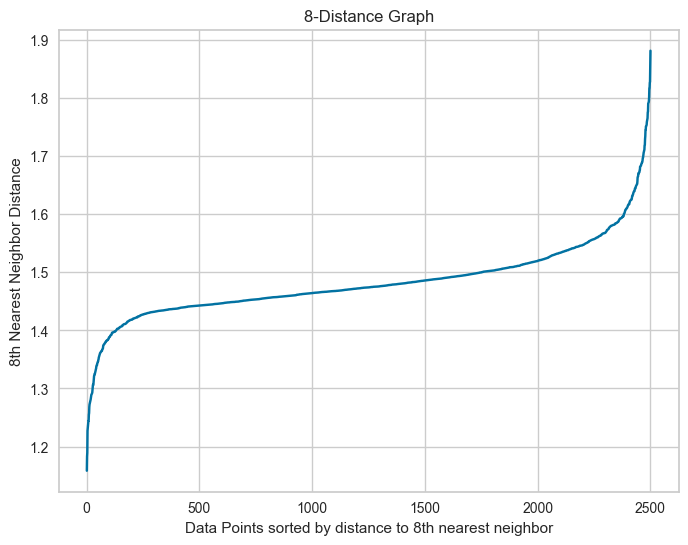

In [248]:
plot_k_distance_graph(text, k=8)

In [249]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1.55, min_samples=8, metric='cosine')
clusters = dbscan.fit_predict(text)

In [250]:
# check amount of items per cluster
unique, counts = np.unique(clusters, return_counts=True)
# print amount of items per cluster
dict(zip(unique, counts))

{0: 2500}

### Expectation Maximization

In [251]:
# tfidf_features = vectorized_data_df
# num_clusters = 7
# em = GaussianMixture(n_components=num_clusters, random_state=42, max_iter=20)
# em.fit(tfidf_features)
# cluster_labels = em.predict(tfidf_features)
# 
# # Evaluate clustering using silhouette score
# silhouette_avg = silhouette_score(tfidf_features, cluster_labels)
# print("Silhouette Score:", silhouette_avg)
# print("BIC:", em.bic(tfidf_features))

In [252]:
# Vectorize the text data
tfidf = TfidfVectorizer()
tfidf.fit(data.preprocessed_concat)
text = tfidf.transform(data.preprocessed_concat)

def plot_bic_aic(text_data, max_components=10):
    bic = []
    aic = []
    n_components_range = range(1, max_components + 1)
    
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(text_data.toarray())
        bic.append(gmm.bic(text_data.toarray()))
        aic.append(gmm.aic(text_data.toarray()))
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(n_components_range, bic, marker='o', label='BIC')
    plt.xlabel('Number of components')
    plt.ylabel('BIC')
    plt.title('BIC vs. Number of components')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(n_components_range, aic, marker='o', label='AIC')
    plt.xlabel('Number of components')
    plt.ylabel('AIC')
    plt.title('AIC vs. Number of components')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage
# plot_bic_aic(text, max_components=10)

In [253]:
def cross_val_log_likelihood(text_data, max_components=10):
    n_components_range = range(1, max_components + 1)
    log_likelihoods = []
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        log_likelihood = 0
        
        for train_index, test_index in skf.split(text_data, np.zeros(text_data.shape[0])):
            gmm.fit(text_data[train_index].toarray())
            log_likelihood += gmm.score(text_data[test_index].toarray())
        
        log_likelihoods.append(log_likelihood / skf.n_splits)
    
    plt.figure(figsize=(8, 6))
    plt.plot(n_components_range, log_likelihoods, marker='o')
    plt.xlabel('Number of components')
    plt.ylabel('Log-Likelihood')
    plt.title('Log-Likelihood vs. Number of components')
    plt.grid(True)
    plt.show()

# Example usage
# cross_val_log_likelihood(text, max_components=10)

### Hierarchical Clustering

#### Agglomerative Clustering

In [254]:
tfidf_features = vectorized_data_df
num_clusters = 7
agg = AgglomerativeClustering(n_clusters=num_clusters, metric='cosine', linkage='average')
agg.fit(tfidf_features)
cluster_labels = agg.labels_

# Evaluate clustering using silhouette score
silhouette_avg = silhouette_score(tfidf_features, cluster_labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.06488688320850462


In [255]:
# Function to calculate cluster validity using proximity and incidence matrices
def cluster_validity_pairwise(data, clusters, metric='euclidean'):
    
    if hasattr(data, "toarray") and not isinstance(data, np.ndarray):
        data = data.toarray()
        
    # Compute the pairwise distances
    pairwise_distances = pdist(data, metric=metric) # One vector with all 'pairwise distances'
    distance_matrix = squareform(pairwise_distances) # Matrix with pairwise distances

    # Creating the incidence matrix
    n_samples = data.shape[0]
    incidence_matrix = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            if clusters[i] == clusters[j]:
                incidence_matrix[i, j] = 1
                incidence_matrix[j, i] = 1

    # Flatten the upper triangle of both matrices to calculate the correlation
    # Since the matrices are symmetric, only the ocrrelation between n(n-1)/2 entries needs to be calculated.
    upper_triangle_indices = np.triu_indices(n_samples, k=1)
    flat_distances = distance_matrix[upper_triangle_indices]
    flat_incidence = incidence_matrix[upper_triangle_indices]

    # Compute the correlation between distances and incidence
    correlation, _ = spearmanr(flat_distances, flat_incidence)
    return correlation


# data = pd.DataFrame({'preprocessed_concat': ["This is the first document.", "This document is the second document.", 
#                                              "And this is the third one.", "Is this the first document?"]})
# Vectorize the text data
# tfidf = TfidfVectorizer()
# tfidf.fit(data.preprocessed_concat)
# text = tfidf.transform(data.preprocessed_concat)

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(vectorized_data)

# Measure Cluster Validity
correlation = cluster_validity_pairwise(vectorized_data, clusters, metric='cosine')
print(f'Cluster Validity Correlation: {correlation:.3f}')

Cluster Validity Correlation: -0.094


In [256]:
# print all entries per cluster
for i in range(7):
    print(f'Cluster {i}:')
    print(data_preprocessed[clusters == i])
    print()

Cluster 0:
      index  amount_of_numbers  \
4         4                  2   
11       11                  8   
12       12                  9   
13       13                  7   
19       19                 14   
...     ...                ...   
2453   2453                  1   
2467   2467                  8   
2477   2477                 16   
2480   2480                  6   
2489   2489                  3   

                                    preprocessed_concat  
4     neet ss result declar counsel schedul soon nat...  
11    tamil nadu halfyearli exam postpon decemb stud...  
12    topper tip cuet ug eas board exam stress cuet ...  
13    icsi cseet novemb exam result declar check sco...  
19    ctet cbse releas januari exam admit card ctetn...  
...                                                 ...  
2453  rbse announc winter vacat rajasthan school dec...  
2467  cuetug topper tip sole refer ncert book say du...  
2477  bhu admiss first allot list ug cours releas to...  


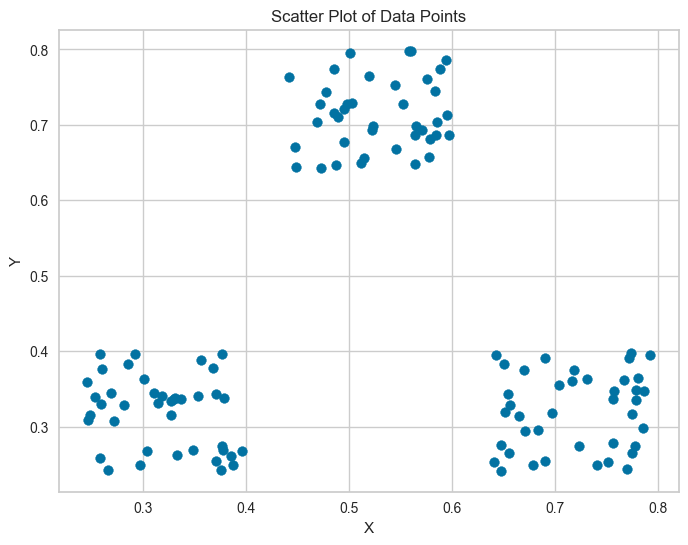

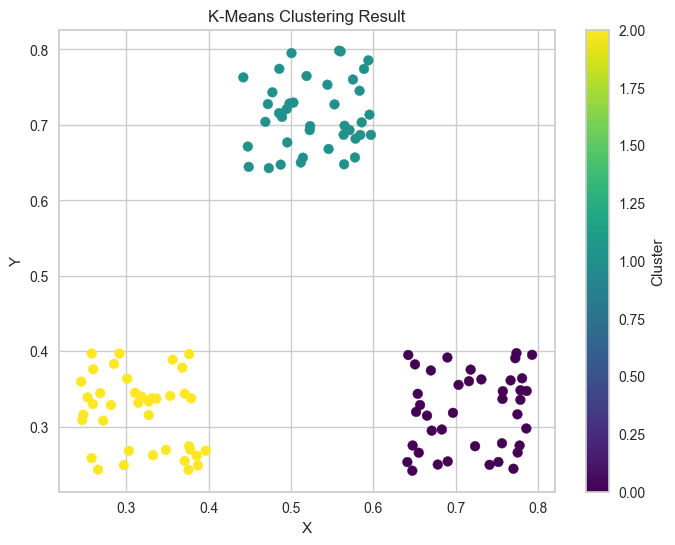

Cluster Validity Correlation: -0.813


In [257]:
# Define the number of points in each cluster
n_points_per_cluster = 40

# Generate coordinates for the first cluster
x1 = np.random.uniform(0.24, 0.4, n_points_per_cluster)
y1 = np.random.uniform(0.24, 0.4, n_points_per_cluster)

# Generate coordinates for the second cluster
x2 = np.random.uniform(0.64, 0.8, n_points_per_cluster)
y2 = np.random.uniform(0.24, 0.4, n_points_per_cluster)

# Generate coordinates for the third cluster
x3 = np.random.uniform(0.44, 0.6, n_points_per_cluster)
y3 = np.random.uniform(0.64, 0.8, n_points_per_cluster)

# Concatenate coordinates for all clusters
x = np.concatenate([x1, x2, x3])
y = np.concatenate([y1, y2, y3])

# Create DataFrame
df = pd.DataFrame({'x': x, 'y': y})


# Generate random coordinates
x = np.random.rand(120)
y = np.random.rand(120)

# Create DataFrame
df_random = pd.DataFrame({'x': x, 'y': y})
# df = df_random

# Visualize the points
plt.figure(figsize=(8, 6))
plt.scatter(df['x'], df['y'])
plt.title('Scatter Plot of Data Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df)

# Visualize the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(df['x'], df['y'], c=clusters, cmap='viridis')
plt.title('K-Means Clustering Result')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Cluster')
plt.show()

correlation = cluster_validity_pairwise(df.values, clusters)
print(f'Cluster Validity Correlation: {correlation:.3f}')

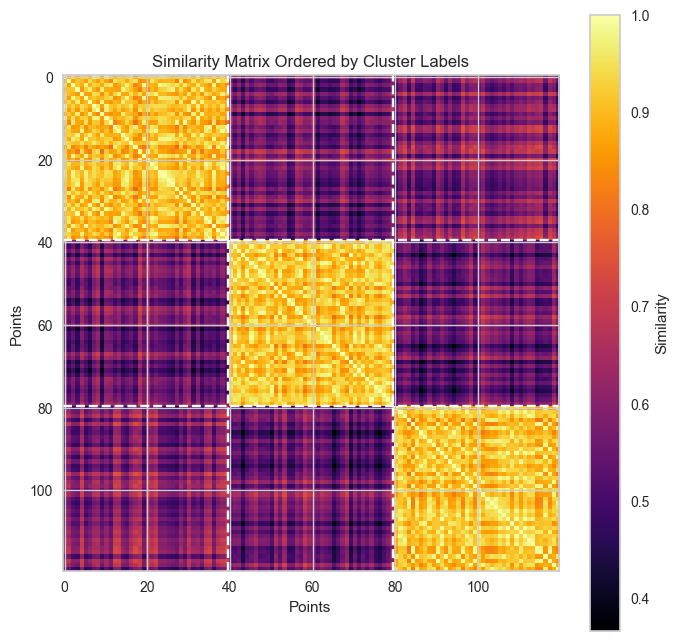

In [258]:
# Function to plot similarity matrix
def plot_similarity_matrix(data, clusters, metric='euclidean'):

    similarity_matrix = 1 - pairwise_distances(data, metric=metric)
    sorted_indices = np.argsort(clusters) # Order the matrix by cluster labels
    sorted_similarity_matrix = similarity_matrix[sorted_indices, :][:, sorted_indices]
    
    # plot similarity matrix
    plt.figure(figsize=(8, 8))
    im = plt.imshow(sorted_similarity_matrix, cmap='inferno', interpolation='nearest')
    
    # colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('Similarity', loc='center')

    # we add lines to separate clusters
    unique_clusters, cluster_counts = np.unique(clusters, return_counts=True)
    cluster_boundaries = np.cumsum(cluster_counts)
    for boundary in cluster_boundaries[:-1]:
        plt.axhline(boundary - 0.5, color='white', linestyle='--')
        plt.axvline(boundary - 0.5, color='white', linestyle='--')
    
    plt.title('Similarity Matrix Ordered by Cluster Labels')
    plt.xlabel('Points')
    plt.ylabel('Points')
    plt.show()

plot_similarity_matrix(df.values, clusters)

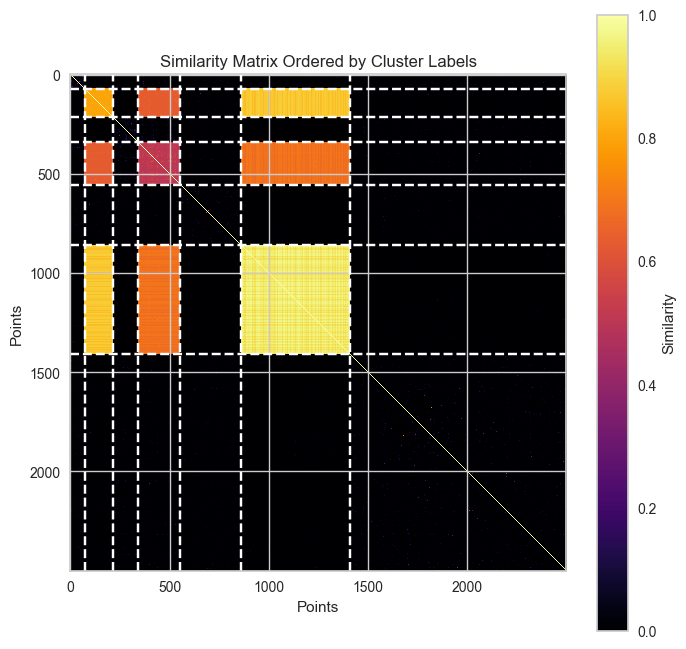

In [259]:
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(cosine_distances(vectorized_data_df))

plot_similarity_matrix(vectorized_data_df, clusters, metric='cosine')

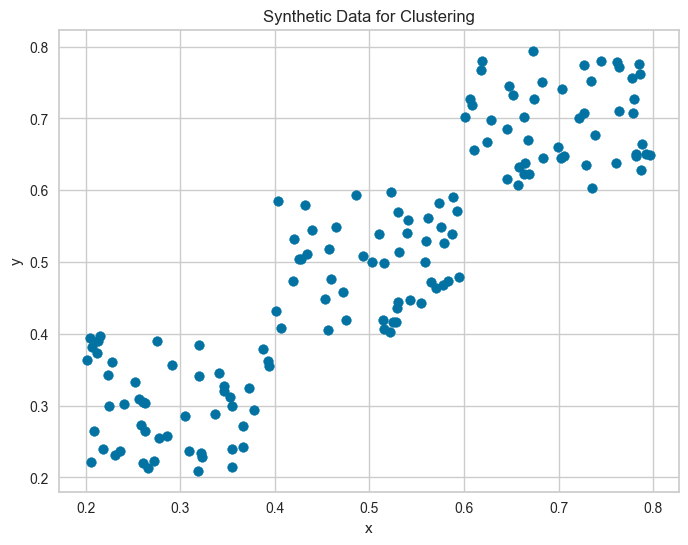

Actual SSE: 8.018
Random SSE Mean: 7.602, Std: 0.431
SSE Z-Score: 0.965
SSE is Atypical: False
---
Actual Silhouette Score: 0.368
Random Silhouette Mean: 0.388, Std: 0.021
Silhouette Z-Score: -0.994
Silhouette Score is Atypical: False
---


(0.9647015474625047, -0.9937042356175201, False, False)

In [269]:
def cluster_validity_statistics(actual_model, actual_clusters, data, n_clusters, n_permutations=100):
    """
    Perform cluster validity statistics by comparing the actual clustering results to random permutations.
    
    Note: a score's atypicality will also be returned as False, if the score is greater than the mean while it should be less and vice versa.
    
    :param data: 
    :param n_clusters: 
    :param n_permutations: 
    :return: 
    """
    actual_sse = actual_model.inertia_
    actual_silhouette = silhouette_score(data, actual_clusters)

    # Generate random permutations and compute SSE and silhouette score
    sse_random = []
    silhouette_random = []
    for _ in range(n_permutations):
        permuted_data = np.apply_along_axis(np.random.permutation, 0, data)
        kmeans_random = KMeans(n_clusters=n_clusters, random_state=42)
        random_clusters = kmeans_random.fit_predict(permuted_data)
        sse_random.append(kmeans_random.inertia_)
        silhouette_random.append(silhouette_score(permuted_data, random_clusters))

    sse_random = np.array(sse_random)
    silhouette_random = np.array(silhouette_random)

    # Calculate mean and standard deviation of the random scores
    sse_mean = sse_random.mean()
    sse_std = sse_random.std()
    silhouette_mean = silhouette_random.mean()
    silhouette_std = silhouette_random.std()

    # Determine if the actual clustering results are atypical
    sse_z_score = (actual_sse - sse_mean) / sse_std
    silhouette_z_score = (actual_silhouette - silhouette_mean) / silhouette_std

    sse_is_atypical = sse_z_score < -2 # we want a negative z-score for sse, which then means it is below the mean
    silhouette_is_atypical = silhouette_z_score > 2 # we want a positive z-score for silhouette score, which then means it is above the mean

    print(f'Actual SSE: {actual_sse:.3f}')
    print(f'Random SSE Mean: {sse_mean:.3f}, Std: {sse_std:.3f}')
    print(f'SSE Z-Score: {sse_z_score:.3f}')
    print(f'SSE is Atypical: {sse_is_atypical}')
    print(f'---')
    print(f'Actual Silhouette Score: {actual_silhouette:.3f}')
    print(f'Random Silhouette Mean: {silhouette_mean:.3f}, Std: {silhouette_std:.3f}')
    print(f'Silhouette Z-Score: {silhouette_z_score:.3f}')
    print(f'Silhouette Score is Atypical: {silhouette_is_atypical}')
    print(f'---')
    
    return sse_z_score, silhouette_z_score, sse_is_atypical, silhouette_is_atypical

# Generate synthetic data for demonstration
np.random.seed(42)
data1 = np.random.uniform(0.2, 0.4, (50, 2))
data2 = np.random.uniform(0.6, 0.8, (50, 2))
data3 = np.random.uniform(0.4, 0.6, (50, 2))
data = np.vstack((data1, data2, data3))

# Plot the clustered data
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1])
plt.title('Synthetic Data for Clustering')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Perform cluster validity statistics
n_clusters = 3
n_permutations = 100
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
actual_clusters = kmeans.fit_predict(df_random)
cluster_validity_statistics(kmeans, actual_clusters, df_random, n_clusters, n_permutations)